<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/interpolate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
Explore bottlenecks for interpolation, in terms of the size of input and size of the grid onto which to interpolate

# Setup


In [2]:
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/coords.py
import coords

from numba import jit

--2021-03-20 15:33:59--  https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/coords.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1681 (1.6K) [text/plain]
Saving to: ‘coords.py’

coords.py           100%[===================>]   1.64K  --.-KB/s    in 0s      

2021-03-20 15:33:59 (32.4 MB/s) - ‘coords.py’ saved [1681/1681]



In [4]:
import matplotlib.pyplot as plt
def doplt(arr2d): return(plt.imshow(arr2d,cmap='gray'))

# 2D Gaussian

In [ ]:
n_values=500
np.random.seed(0)
XY = np.random.multivariate_normal(mean=(0,0),cov=np.eye(2),size=n_values)
percentile = np.percentile(np.abs(XY.flatten()),q=95)
good_idx = (np.abs(XY) > percentile).sum(1)==0
abs_max = np.abs(XY[good_idx]).max()
# XY = XY[good_idx]
Z = np.exp(-(XY**2).sum(1)/2)
abs_max

1.9559123082506942

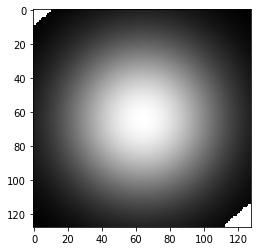

In [ ]:
n_grid = 128
xi = coords.coords_n_by_d(np.arange(start=-n_grid//2,stop=n_grid//2),d=2) #/ (n_grid//2)
xi_match = xi / (n_grid//2) * abs_max # [-1,1)
Z_grid = griddata(points=XY,values=Z,xi=xi_match,method='cubic')

doplt(Z_grid.reshape(n_grid,n_grid))

# $O(?)$ in `len(xi)`

With fixed number of `points` from `XY`, and of course matching fixed number of `values` from `Z`, let's see how the runtime scales with different sized query points `xi`

In [ ]:
for n_grid in [64,128,256,512,1024]:
  xi = coords.coords_n_by_d(np.arange(start=-n_grid//2,stop=n_grid//2),d=2) #/ (n_grid//2)
  xi_match = xi / (n_grid//2) * abs_max # [-1,1)
  %timeit griddata(points=XY,values=Z,xi=xi_match)
Z_grid = griddata(points=XY,values=Z,xi=xi_match)

10 loops, best of 5: 137 ms per loop
10 loops, best of 5: 136 ms per loop
10 loops, best of 5: 140 ms per loop
10 loops, best of 5: 155 ms per loop
1 loop, best of 5: 204 ms per loop


These doesn't seem to be much dependence on the grid size, perhaps a log scale dependence.

# $O(?)$ in `len(values)`

Now with fixed number of query points `xi`, let's see how the runtime scales with different number of `points` from `XY`, and of course matching number of `values` from `Z`.

In [ ]:
n_values_li = [10**x for x in [2,3,4,5,6]]
timings = np.zeros(len(n_values_li))
for idx,n_values in enumerate(n_values_li):
  np.random.seed(0)
  XY = np.random.multivariate_normal(mean=(0,0),cov=np.eye(2),size=n_values)
  percentile = np.percentile(np.abs(XY.flatten()),q=95)
  good_idx = (np.abs(XY) > percentile).sum(1)==0
  abs_max = np.abs(XY[good_idx]).max()
  Z = np.exp(-(XY**2).sum(1)/2)

  n_grid = 64
  xi = coords.coords_n_by_d(np.arange(start=-n_grid//2,stop=n_grid//2),d=2) #/ (n_grid//2)
  xi_match = xi / (n_grid//2) * abs_max # [-1,1)
  func1_time = %timeit -o griddata(points=XY,values=Z,xi=xi_match,method='linear')
  timings[idx] = func1_time.best

1000 loops, best of 5: 1.59 ms per loop
100 loops, best of 5: 12.8 ms per loop
10 loops, best of 5: 136 ms per loop
1 loop, best of 5: 1.82 s per loop
1 loop, best of 5: 19.7 s per loop


Text(0.5, 1.0, 'O(const * n_values) ; const = 19.8 us/value ')

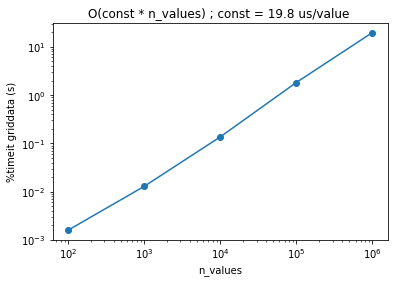

In [ ]:
sr = pd.Series(timings)
sr.index = n_values_li
ax = sr.plot(marker='o',logx=True,logy=True)
ax.set_xlabel('n_values')
ax.set_ylabel('%timeit griddata (s)')
slope = (timings[-1] - timings[-3]) / (n_values_li[-1]-n_values_li[-3])
ax.set_title('O(const * n_values) ; const = %.1f us/value '%(slope*1e6))

For every extra value, griddata will take 24 to 27 us more. The trend it sublinear up to a few thousand for larger n_grid (256,512), but then become linear after that. And this is independent of the size of the grid onto which to sample it, which can be fine or coarse.

|d|n_grid|%timeit griddata (us/value)|
|-|-|-|
|2|64|26.5 |
|2| 128|25 |
|2|256|24.1|
|2|512|26.6|

# 3D Gaussian

In [ ]:
n_values=10**6
d=3
np.random.seed(0)
XYZ = np.random.multivariate_normal(mean=np.zeros(d),cov=np.eye(d),size=n_values)
percentile = np.percentile(np.abs(XYZ.flatten()),q=95)
good_idx = (np.abs(XYZ) > percentile).sum(1)==0
abs_max = np.abs(XYZ[good_idx]).max()
# XY = XY[good_idx]
F = np.exp(-(XYZ**2).sum(1)/2)

abs_max

1.9581565358354729

In [ ]:
n_grid = 512
xi = coords.coords_n_by_d(np.arange(start=-n_grid//2,stop=n_grid//2),d=d) #/ (n_grid//2)
xi_match = xi / (n_grid//2) * abs_max # [-1,1)
F_grid = griddata(points=XYZ,values=F,xi=xi_match)



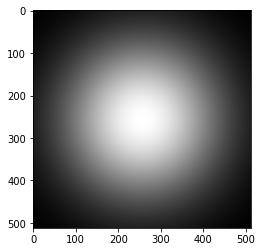

In [ ]:
doplt(np.nanmean(F_grid.reshape(n_grid,n_grid,n_grid),0))

The 3D interpolation is working. Let's see how this scales.

In [ ]:
n_values_li = [10**x for x in [2,3,4,5,6]]
timings = np.zeros(len(n_values_li))
for idx,n_values in enumerate(n_values_li):
  np.random.seed(0)
  XYZ = np.random.multivariate_normal(mean=np.zeros(d),cov=np.eye(d),size=n_values)
  percentile = np.percentile(np.abs(XYZ.flatten()),q=95)
  good_idx = (np.abs(XYZ) > percentile).sum(1)==0
  abs_max = np.abs(XYZ[good_idx]).max()
  F = np.exp(-(XYZ**2).sum(1)/2)

  n_grid = 512
  xi = coords.coords_n_by_d(np.arange(start=-n_grid//2,stop=n_grid//2),d=d) #/ (n_grid//2)
  xi_match = xi / (n_grid//2) * abs_max # [-1,1)
  griddata_time = %timeit -o griddata(points=XYZ,values=F,xi=xi_match,method='linear')
  timings[idx] = griddata_time.best

1 loop, best of 5: 8.87 s per loop
1 loop, best of 5: 10.8 s per loop
1 loop, best of 5: 12.4 s per loop
1 loop, best of 5: 22.6 s per loop
1 loop, best of 5: 1min 57s per loop


Text(0.5, 1.0, 'O(const * n_values) ; const = 105.4 us/value ')

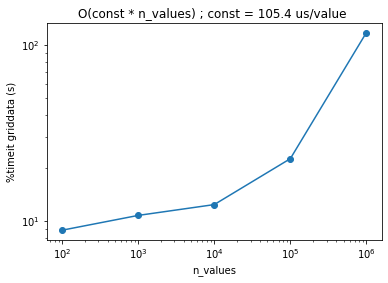

In [ ]:
sr = pd.Series(timings)
sr.index = n_values_li
ax = sr.plot(marker='o',logx=True,logy=True)
ax.set_xlabel('n_values')
ax.set_ylabel('%timeit griddata (s)')
slope = (timings[-1] - timings[-2]) / (n_values_li[-1]-n_values_li[-2])
ax.set_title('O(const * n_values) ; const = %.1f us/value '%(slope*1e6))

In [ ]:
timings[-1]/n_values_li[-1]

0.0001174606974060007

For every extra value, griddata will take 100 to 111 us more. The trend it sublinear up to a few thousand for larger n_grid (256,512), but then become linear after that. And this is independent of the size of the grid onto which to sample it, which can be fine or coarse.

|n_grid|%timeit griddata (us/value)|
|-|-|
| 64|100.5|
| 128| |
|256||
|512|108-111|

We can see now in 3D, the trend is the same, but the constant is larger. There still is practically no dependence on `n_grid`.



# Parralelization

When we are doing Fourier inversion, for a box size of N, and $n_p$ particles we would have $N^2n_p$ (complex) values on an $N^3$ sized grid. For 10k particles and $N \in \{64,126,256,512\}$ this would be \{41,163,655,2621\} million complex numbers to interpolate. Surely something parralelized and fast is doing this, and not griddata, which would take \{1.1,4.6,18,73\} hours.

Parralelization could be leveraged if the interpolated slices can just be added to each other. We could do the interpolations in batches in parallel, and then bring them together at the end. Essentially doing averages step by step.

* https://stackoverflow.com/questions/14015114/scipy-interpolate-griddata-equivalent-in-cuda
* https://dypy.readthedocs.io/en/latest/intergrid.html

# Bicubic interpolation
The section *Bicubic interpolation polynomial* [here](https://www.paulinternet.nl/?page=bicubic) gives the coefficients $a_{ij}$ for 
$$
g(x,y) = \sum_{ij}a_{ij}x^iy^j = a_{00} + a_{10}x + a_{11}xy + ... + a_{32}x^3y^2 + a_{33}x^3y^3 
$$

$a_{ij}$ is given in terms of the "16 points pij, with i and j going from 0 to 3 and with pij located at (i-1, j-1)"

We can hard code this and try out a simple example and compare the function to the bicubic interpolated estimate

Function: a simple gaussian

In [ ]:
N=16
xv,yv = np.meshgrid(np.arange(-N//2,N//2),np.arange(-N//2,N//2))

def gauss(x,y,mux=0,muy=0,sigma=4):
  r2 = (x-mux)**2+(y-muy)**2
  g = np.exp(-r2/(2*sigma**2))
  return(g)

sigma=4
f = gauss(xv,yv,sigma=sigma)

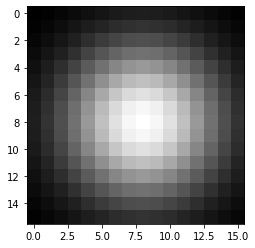

In [ ]:
doplt(f)

We are going to interpolate based on the 16 points from the inner 4x4 array 

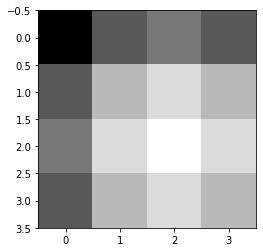

In [ ]:
mid=N//2 # 8
p = f[mid-2:mid+2,mid-2:mid+2] # -2,-1,0,1
doplt(p)

In [ ]:
xv[mid-2:mid+2,mid-2:mid+2], yv[mid-2:mid+2,mid-2:mid+2]

(array([[-2, -1,  0,  1],
        [-2, -1,  0,  1],
        [-2, -1,  0,  1],
        [-2, -1,  0,  1]]), array([[-2, -2, -2, -2],
        [-1, -1, -1, -1],
        [ 0,  0,  0,  0],
        [ 1,  1,  1,  1]]))

Thankfully I can copy/paste the code from the link

In [ ]:
def bicubic_coeff(p):
  a00 = p[1][1];
  a01 = -.5*p[1][0] + .5*p[1][2];
  a02 = p[1][0] - 2.5*p[1][1] + 2*p[1][2] - .5*p[1][3];
  a03 = -.5*p[1][0] + 1.5*p[1][1] - 1.5*p[1][2] + .5*p[1][3];
  a10 = -.5*p[0][1] + .5*p[2][1];
  a11 = .25*p[0][0] - .25*p[0][2] - .25*p[2][0] + .25*p[2][2];
  a12 = -.5*p[0][0] + 1.25*p[0][1] - p[0][2] + .25*p[0][3] + .5*p[2][0] - 1.25*p[2][1] + p[2][2] - .25*p[2][3];
  a13 = .25*p[0][0] - .75*p[0][1] + .75*p[0][2] - .25*p[0][3] - .25*p[2][0] + .75*p[2][1] - .75*p[2][2] + .25*p[2][3];
  a20 = p[0][1] - 2.5*p[1][1] + 2*p[2][1] - .5*p[3][1];
  a21 = -.5*p[0][0] + .5*p[0][2] + 1.25*p[1][0] - 1.25*p[1][2] - p[2][0] + p[2][2] + .25*p[3][0] - .25*p[3][2];
  a22 = p[0][0] - 2.5*p[0][1] + 2*p[0][2] - .5*p[0][3] - 2.5*p[1][0] + 6.25*p[1][1] - 5*p[1][2] + 1.25*p[1][3] + 2*p[2][0] - 5*p[2][1] + 4*p[2][2] - p[2][3] - .5*p[3][0] + 1.25*p[3][1] - p[3][2] + .25*p[3][3];
  a23 = -.5*p[0][0] + 1.5*p[0][1] - 1.5*p[0][2] + .5*p[0][3] + 1.25*p[1][0] - 3.75*p[1][1] + 3.75*p[1][2] - 1.25*p[1][3] - p[2][0] + 3*p[2][1] - 3*p[2][2] + p[2][3] + .25*p[3][0] - .75*p[3][1] + .75*p[3][2] - .25*p[3][3];
  a30 = -.5*p[0][1] + 1.5*p[1][1] - 1.5*p[2][1] + .5*p[3][1];
  a31 = .25*p[0][0] - .25*p[0][2] - .75*p[1][0] + .75*p[1][2] + .75*p[2][0] - .75*p[2][2] - .25*p[3][0] + .25*p[3][2];
  a32 = -.5*p[0][0] + 1.25*p[0][1] - p[0][2] + .25*p[0][3] + 1.5*p[1][0] - 3.75*p[1][1] + 3*p[1][2] - .75*p[1][3] - 1.5*p[2][0] + 3.75*p[2][1] - 3*p[2][2] + .75*p[2][3] + .5*p[3][0] - 1.25*p[3][1] + p[3][2] - .25*p[3][3];
  a33 = .25*p[0][0] - .75*p[0][1] + .75*p[0][2] - .25*p[0][3] - .75*p[1][0] + 2.25*p[1][1] - 2.25*p[1][2] + .75*p[1][3] + .75*p[2][0] - 2.25*p[2][1] + 2.25*p[2][2] - .75*p[2][3] - .25*p[3][0] + .75*p[3][1] - .75*p[3][2] + .25*p[3][3];
  a = np.array([a00,a01,a02,a03,a10,a11,a12,a13,a20,a21,a22,a23,a30,a31,a32,a33])
  return(a00,a01,a02,a03,a10,a11,a12,a13,a20,a21,a22,a23,a30,a31,a32,a33)
a = bicubic_coeff(p)

Now I want to interpolate at many values on $[-2,1] \text{x} [-2,1]$

In [ ]:
step_interp = 1
offset=1
vals_interp = np.arange(-2+offset,1+offset+step_interp,step=step_interp) # many points
vals_interp
x, y = np.meshgrid(vals_interp,vals_interp)
x.shape

(4, 4)

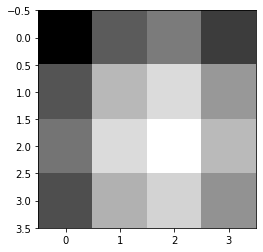

In [ ]:
def bicubic_interp(a,x,y):
  x2 = x * x;
  x3 = x2 * x2;
  y2 = y * y;
  y3 = y2 * y;

  g = (a00 + a01 * y + a02 * y2 + a03 * y3) + \
            (a10 + a11 * y + a12 * y2 + a13 * y3) * x + \
            (a20 + a21 * y + a22 * y2 + a23 * y3) * x2 + \
            (a30 + a31 * y + a32 * y2 + a33 * y3) * x3
  return(g)
g = bicubic_interp(a,x,y)
doplt(g)

In [ ]:
g

array([[0.78371096, 0.86073811, 0.88806087, 0.83603241],
       [0.85534533, 0.93941306, 0.96923323, 0.91244917],
       [0.8824969 , 0.96923323, 1.        , 0.94141341],
       [0.85043515, 0.93402028, 0.96366927, 0.90721117]])

In [ ]:
p

array([[0.77880078, 0.85534533, 0.8824969 , 0.85534533],
       [0.85534533, 0.93941306, 0.96923323, 0.93941306],
       [0.8824969 , 0.96923323, 1.        , 0.96923323],
       [0.85534533, 0.93941306, 0.96923323, 0.93941306]])

Let's try with a finder grid. Note that we do not recomptue the coefficients, just change the points we want to compute the inerpolated function at

In [ ]:
step_interp = .1
offset=1
vals_interp = np.arange(-2+offset,1+offset+step_interp,step=step_interp) # many points
vals_interp
x, y = np.meshgrid(vals_interp,vals_interp)
x.shape

(31, 31)

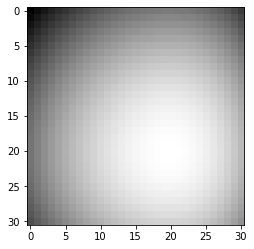

In [ ]:
g = bicubic_interp(a,x,y)
doplt(g)

We can compare the interpolated values on this finer grid, with the actual function values (we know the function, it's the gaussian). This will tell us how well bicubic interpolations works for this function, which depends on how fast the gaussian is decaying and how many terms are needed to approx it over the 16 points used in the bicibic interpolation)

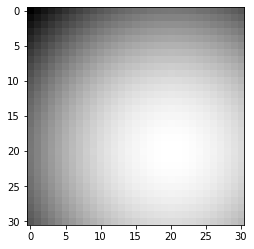

In [ ]:
g_fine = gauss(x-offset,y-offset,sigma=sigma)
doplt(g_fine)

Error

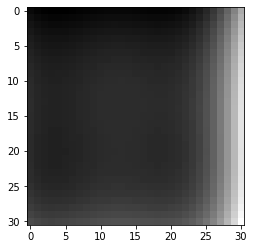

In [ ]:
doplt(g_fine-g)

# Source of `scipy.interpolate.griddata`
* https://github.com/scipy/scipy/blob/v1.5.4/scipy/interpolate/interpnd.pyx
  * in linear interpolation qhull is used. a likey bottleneck is computing the convex hull of the points http://media.steampowered.com/apps/valve/2014/DirkGregorius_ImplementingQuickHull.pdf

# Trilinear intrpolation
* See https://github.com/3dem/relion/blob/master/src/backprojector.cpp#L227
* If we have values Fxyz in Fourier space at (kx,ky,kz) we can distribute Fxyz into the neighbouring 8 voxels on the cartesian grid. 
* We can also keep track of the proportionate contribution that went into these voxels, and keep a running sum, to divide out later
* In this way we can add in one slice at a time, and since each slice is independent from each other, we can parallelize the interpolation

Let's look at a simple example or a gaussian 2D disk rotated by $ZYZ$ Euler angles $(0,\beta,0)$. We should be able to interpolate it into 3D, and then project it on the xy plane and see the rotated/squished disk.

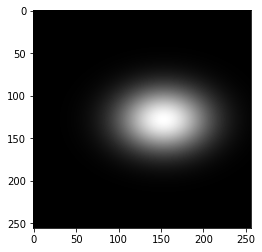

In [244]:
N=256
coords_1d = np.arange(-N//2,N//2)
x,y = np.meshgrid(coords_1d,coords_1d)
sigmax,sigmay=N/7, N/10
mux = 25
r2 = (x-mux)**2/sigmax**2+y**2/sigmay**2
F = np.exp(-r2/2)
doplt(F)

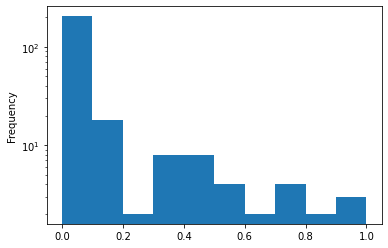

In [117]:
pd.Series(F.flatten()).plot.hist(logy=True)

In [245]:
R = coords.EA_to_R3(np.deg2rad(45),np.deg2rad(0),0)
xy0 = coords.coords_n_by_d(coords_1d,d=3)
xy0 = xy0[xy0[:,-1] == 0]
xy0_rot = R.dot(xy0.T).T

In [246]:
# corresponds to x0,x1,fx,mfx, but vectorized for r=(x,y,z)
def diff(xy0_rot):
  r0 = np.floor(xy0_rot).astype(np.int)
  r1 = r0+1
  fr = xy0_rot - r0
  mfr = 1-fr
  # assert fr.min() >= 0 and mfr.min() >= 0 
  mfx,mfy,mfz = mfr[:,0], mfr[:,1], mfr[:,-1]
  fx,fy,fz = fr[:,0], fr[:,1], fr[:,-1]
  dd000 = mfz * mfy * mfx;
  dd001 = mfz * mfy *  fx;
  dd010 = mfz *  fy * mfx;
  dd011 = mfz *  fy *  fx;
  dd100 =  fz * mfy * mfx;
  dd101 =  fz * mfy *  fx;
  dd110 =  fz *  fy * mfx;
  dd111 =  fz *  fy *  fx;
  dd = np.array([dd000,dd001,dd010,dd011,dd100,dd101,dd110,dd111])
  return(r0,r1,dd)
r0,r1,dd = diff(xy0_rot)

In [247]:
def interp(F,r0,r1,dd,N):
  F_3d_interp = np.zeros((N,N,N))
  count_3d_interp = np.zeros((N,N,N))
  ones = np.ones(N*N)
  F_flat = F.flatten()

  def fill(F_3d_interp,zint,yint,xint,dd,idx,F_flat,N,do_print):
    rint = np.array([xint,yint,zint])
    if rint.min() >= 0 and rint.max() < N:
      F_3d_interp[xint,yint,zint] += dd[idx]*F_flat[idx] # remember +=
    else:
      if do_print: print('bad idx',idx,rint,'value',F_flat[idx])

  dd000,dd001,dd010,dd011,dd100,dd101,dd110,dd111 = dd
  for idx in np.arange(F.size):
    x0,y0,z0 = (r0+N//2)[idx].astype(np.int)
    x1,y1,z1 = (r1+N//2)[idx].astype(np.int)
    do_print=False
    fill(F_3d_interp,z0,y0,x0,dd000,idx,F_flat,N,do_print)
    fill(F_3d_interp,z0,y0,x1,dd001,idx,F_flat,N,do_print)
    fill(F_3d_interp,z0,y1,x0,dd010,idx,F_flat,N,do_print)
    fill(F_3d_interp,z0,y1,x1,dd011,idx,F_flat,N,do_print)
    fill(F_3d_interp,z1,y0,x0,dd100,idx,F_flat,N,do_print)
    fill(F_3d_interp,z1,y0,x1,dd101,idx,F_flat,N,do_print)
    fill(F_3d_interp,z1,y1,x0,dd110,idx,F_flat,N,do_print)
    fill(F_3d_interp,z1,y1,x1,dd111,idx,F_flat,N,do_print)

    do_print=False
    fill(count_3d_interp,z0,y0,x0,dd000,idx,ones,N,do_print)
    fill(count_3d_interp,z0,y0,x1,dd001,idx,ones,N,do_print)
    fill(count_3d_interp,z0,y1,x0,dd010,idx,ones,N,do_print)
    fill(count_3d_interp,z0,y1,x1,dd011,idx,ones,N,do_print)
    fill(count_3d_interp,z1,y0,x0,dd100,idx,ones,N,do_print)
    fill(count_3d_interp,z1,y0,x1,dd101,idx,ones,N,do_print)
    fill(count_3d_interp,z1,y1,x0,dd110,idx,ones,N,do_print)
    fill(count_3d_interp,z1,y1,x1,dd111,idx,ones,N,do_print)
  
  return(F_3d_interp,count_3d_interp)

%time F_3d_interp_nv,count_3d_interp_nv = interp(F,r0,r1,dd,N)

CPU times: user 43 s, sys: 1.77 s, total: 44.8 s
Wall time: 44.9 s


In [214]:
# np.argwhere(~good_idx).T
#pd.Series(F_flat[~good_idx]).hist()


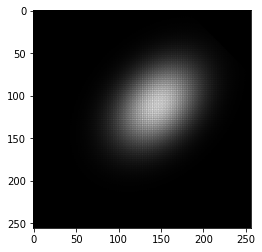

In [248]:
F_proj = F_3d_interp_nv.sum(-1)
doplt(F_proj)

We see some artefacts here. When we divide out by the counts, this goes away.

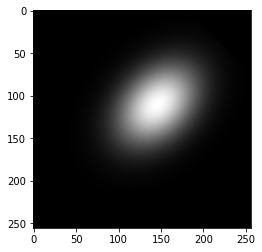

In [249]:
nonzeromin = count_3d_interp_nv[np.nonzero(count_3d_interp_nv)].min()
F_proj_nv = (F_3d_interp_nv/(nonzeromin+count_3d_interp_nv)).sum(-1)
doplt(F_proj_nv)

## vectorized
The new vectorized function is .12s instead of 45s, so a ~375x speedup!

vectorize for speetup

To vectorize multiple look ups of `F[k,j,i]` (`F` is an `np.ndarray`) for many tupples of $kji$, we can do `F[[k1,...,kn],[j1,...,jn],[i1,...,in]]`

In [250]:
def interp_vec(F,r0,r1,dd,N):

  # F_idx_x, F_idx_y = (xy0 + N//2)[:,[0,1]].astype(np.int).T # unrotated indeces
  # F[F_idx_x,F_idx_y] # just F flattened!


  r0_idx = r0 + N//2
  r1_idx = r1 + N//2

  under_grid_idx = np.any(r0_idx < 0,axis=1)
  over_grid_idx = np.any(r1_idx >= N,axis=1)
  good_idx = np.logical_and(~under_grid_idx,~over_grid_idx)


  F_3d_interp = np.zeros((N,N,N))
  count_3d_interp = np.zeros((N,N,N))
  ones = np.ones(N*N)[good_idx]
  F_flat = F.flatten()[good_idx]

  r0_idx_good = r0_idx[good_idx]
  r1_idx_good = r1_idx[good_idx]

  def fill_vec(F_3d_interp,r0_idx_good,r1_idx_good,F_flat_good,dd):
    dd000,dd001,dd010,dd011,dd100,dd101,dd110,dd111 = dd

    F_3d_interp[r0_idx_good[:,0], r0_idx_good[:,1], r0_idx_good[:,-1]] += F_flat_good*dd000 # 000
    F_3d_interp[r1_idx_good[:,0], r0_idx_good[:,1], r0_idx_good[:,-1]] += F_flat_good*dd001 # 001
    F_3d_interp[r0_idx_good[:,0], r1_idx_good[:,1], r0_idx_good[:,-1]] += F_flat_good*dd010 # 010
    F_3d_interp[r1_idx_good[:,0], r1_idx_good[:,1], r0_idx_good[:,-1]] += F_flat_good*dd011 # 011

    F_3d_interp[r0_idx_good[:,0], r0_idx_good[:,1], r1_idx_good[:,-1]] += F_flat_good*dd100 # 100
    F_3d_interp[r1_idx_good[:,0], r0_idx_good[:,1], r1_idx_good[:,-1]] += F_flat_good*dd101 # 101
    F_3d_interp[r0_idx_good[:,0], r1_idx_good[:,1], r1_idx_good[:,-1]] += F_flat_good*dd110 # 110
    F_3d_interp[r1_idx_good[:,0], r1_idx_good[:,1], r1_idx_good[:,-1]] += F_flat_good*dd111 # 111
    return(F_3d_interp)

  F_3d_interp = fill_vec(F_3d_interp,r0_idx_good,r1_idx_good,F_flat,dd[:,good_idx])
  count_3d_interp = fill_vec(count_3d_interp,r0_idx_good,r1_idx_good,ones,dd[:,good_idx])

    
  return(F_3d_interp,count_3d_interp)

%time F_3d_interp,count_3d_interp = interp_vec(F,r0,r1,dd,N)

CPU times: user 141 ms, sys: 1.88 ms, total: 143 ms
Wall time: 143 ms


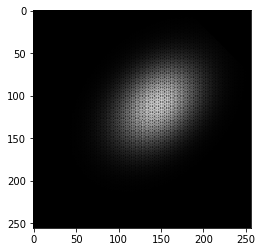

In [251]:
F_proj = F_3d_interp.sum(-1)
doplt(F_proj)

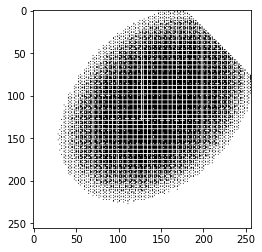

In [254]:
doplt(np.isclose(F_3d_interp_nv.sum(-1),F_3d_interp.sum(-1),atol=1e-3))

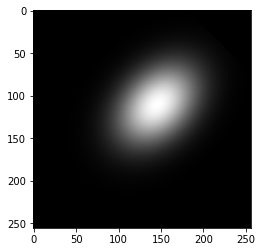

In [255]:
nonzeromin = count_3d_interp[np.nonzero(count_3d_interp)].min()
F_proj = (F_3d_interp/(nonzeromin+count_3d_interp)).sum(-1)
doplt(F_proj)

0.22591514060943124

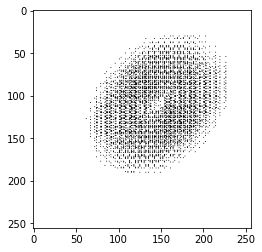

In [256]:
doplt(np.isclose(F_proj_nv,F_proj,atol=1e-3))
np.linalg.norm(F_proj_nv-F_proj)

The non vectorized and vectorized methods do not agree, and have an L2 norm of .22

It's not only important to normalize it by the counts, but also important to get the `nonzeromin` constant right. If it's too large we get artefacts

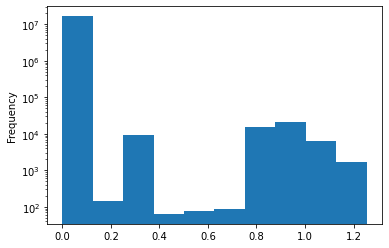

In [257]:
pd.Series(count_3d_interp.flatten()).plot.hist(logy=True)

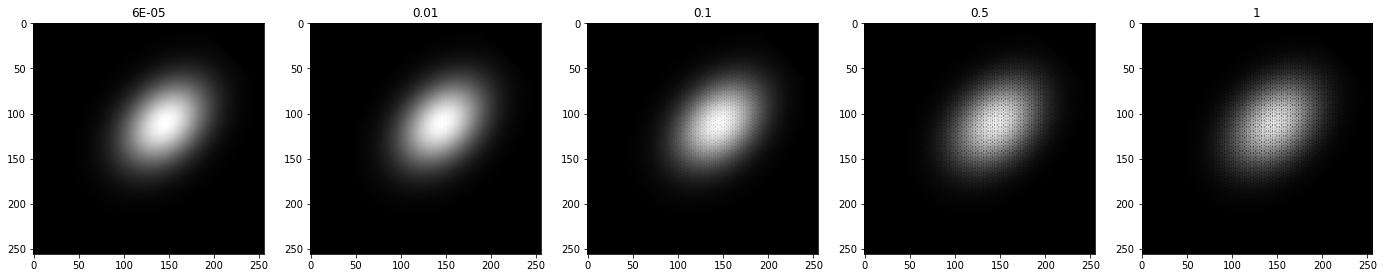

In [258]:
consts =  [nonzeromin,0.01,0.1,.5,1]
fig,axes = plt.subplots(nrows=1,ncols=len(consts),figsize=(24,32))
for idx,const in enumerate(consts):
  F_proj = (F_3d_interp/(const+count_3d_interp)).sum(-1)
  if const < 0.01: const = '%.0E'%const
  axes[idx].imshow(F_proj,cmap='gray') ; axes[idx].set_title(const)

Let's try another rotation, and see how the artefacts look.

In [259]:
R = coords.EA_to_R3(np.deg2rad(0),np.deg2rad(45),0)
xy0 = coords.coords_n_by_d(coords_1d,d=3)
xy0 = xy0[xy0[:,-1] == 0]
xy0_rot = R.dot(xy0.T).T

In [260]:
r0,r1,dd = diff(xy0_rot)

In [261]:
F_3d_interp,count_3d_interp = interp_vec(F,r0,r1,dd,N)

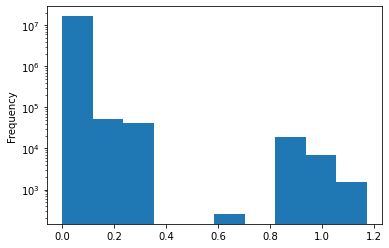

In [262]:
pd.Series(count_3d_interp.flatten()).plot.hist(logy=True)

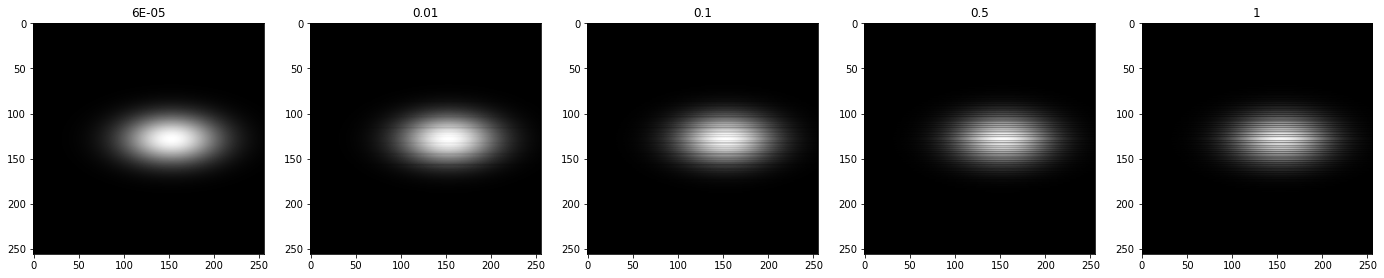

In [263]:
consts =  [nonzeromin,0.01,0.1,.5,1]
fig,axes = plt.subplots(nrows=1,ncols=len(consts),figsize=(24,32))
for idx,const in enumerate(consts):
  F_proj = (F_3d_interp/(const+count_3d_interp)).sum(-1)
  if const < 0.01: 
    const = '%.0E'%const
  elif const < 0.1:
    const = '%.2f'%const
  axes[idx].imshow(F_proj,cmap='gray') ; axes[idx].set_title(const)

Note that how the artefacts look depends on the rotation. It looks like there can be systematic artefacts.

## $O(f(N))$
Let's see how the interpolation scales with larger box sizes.

In [275]:
Ns=np.array([2**n for n in [5,6,7,8,9]])
timings = np.zeros(len(Ns))

for idx,N in enumerate(Ns):
  coords_1d = np.arange(-N//2,N//2)
  x,y = np.meshgrid(coords_1d,coords_1d)
  sigmax,sigmay=N/7, N/10
  mux = 25
  r2 = (x-mux)**2/sigmax**2+y**2/sigmay**2
  F = np.exp(-r2/2)

  R = coords.EA_to_R3(np.deg2rad(0),np.deg2rad(45),0)
  xy0 = coords.coords_n_by_d(coords_1d,d=3)
  xy0 = xy0[xy0[:,-1] == 0]
  xy0_rot = R.dot(xy0.T).T

  r0,r1,dd = diff(xy0_rot)

  func1_time = %timeit -o F_3d_interp,count_3d_interp = interp_vec(F,r0,r1,dd,N)
  timings[idx] = func1_time.best


1000 loops, best of 5: 623 µs per loop
100 loops, best of 5: 3.18 ms per loop
100 loops, best of 5: 17.5 ms per loop
10 loops, best of 5: 118 ms per loop
1 loop, best of 5: 722 ms per loop


Text(0.5, 1.0, '$O(const * N^2)$ ; const = 2.9 us/pixel ')

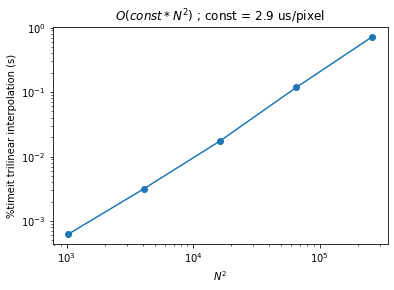

In [287]:
sr = pd.Series(timings)
sr.index = Ns**2
ax = sr.plot(marker='o',logx=True,logy=True)
ax.set_xlabel('$N^2$')
ax.set_ylabel('%timeit trilinear interpolation (s)')
slope = (timings[-1] - timings[-3]) / (Ns[-1]**2-Ns[-3]**2)
ax.set_title(r'$O(const * N^2)$ ; const = %.1f us/pixel '%(slope*1e6))

In [298]:
timings, 

(array([6.22643086e-04, 3.18226705e-03, 1.74970081e-02, 1.17875871e-01,
        7.21835682e-01]), array([  1024,   4096,  16384,  65536, 262144]))

In [300]:
slope*Ns**2

array([0.00293474, 0.01173898, 0.04695591, 0.18782365, 0.75129459])

The interpolation is linear with the number of pixels in a slice (which is squared with the box size). It takes ~3us/pixel to interpolate. 

When we are doing Fourier inversion, for a box size of N, and $n_p$ particles we would have $N^2n_p$ (complex) values on an $N^3$ sized grid. For 10k particles and $N \in \{32,64,126,256,512\}$ this would be \{41,163,655,2621\} million complex numbers to interpolate. Without parralelization that would take \{.0082,.033,.13,.52,2.1\} hours. With parralelization, where each particle can be interpolated at the same time, this reduces by a factor of  $n_p$ to \{0.0039,0.012,0.047,0.19,0.75\} seconds.

In [303]:
n_particles=1e4
sec_per_hr = 60*60
slope*Ns**2*n_particles/sec_per_hr # in hrs

array([8.15206798e-07, 3.26082719e-06, 1.30433088e-05, 5.21732351e-05,
       2.08692940e-04])

In [304]:
n_particles=1
slope*Ns**2*n_particles # in seconds

array([0.00293474, 0.01173898, 0.04695591, 0.18782365, 0.75129459])